In [2]:
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import math
from sklearn.model_selection import train_test_split
import pickle

pd.options.display.float_format = '{:20,.2f}'.format # formatting

## Load Data
Data is given in separate csv files. Append to form 1 main data table. 

In [3]:
## Initial load
# Loading features data 
path = r'../data/features'
all_files = glob.glob(path + "/*.csv")
df = pd.concat(pd.read_csv(f) for f in all_files)

# Loading the labels file
labels = pd.read_csv("../data/labels/part-00000-e9445087-aa0a-433b-a7f6-7f4c19d78ad6-c000.csv")

In [4]:
# ## Subsequent loads
# # load features data ; change file path accordingly
# fpath = "../data/features/sorted.pkl"
# data = pickle.load(open(fpath,'rb'))
# labels = pd.read_csv("../data/labels/cleaned_labels.csv", index_col=0)

### Data Cleaning
Steps taken:
1. Remove **duplicate** bookingIDs from both datasets
2. **Sort** the dataset so we can easily compare consecutive records. 
3.	Remove **Inaccurate records**, and treat them as missing records. Inaccurate i.e.:
    - `second` >= 10000 (Drill down also shows that these high numbers are not continuous with their preceding 'correct' records.) 
    - `Speed` < 0 (physically impossible)
4. Remove **Inaccurate trips**, i.e.:
    - (?) Long trips, with largest known `second` is > 2 hours. 
    - Trips where the % of data collected/entire known duration of the trip (highest recorded `second`) is > 90%. 
    - Only some records at the end of the trip which are negative – the rest are correct. (Number of records = `Max(second)`) 
5.	Missing Records **Imputation**
    - Some bookingIDs have missing records, including those we have removed earlier for being inaccurate. 
    - We will use rolling window to impute these missing records *only* if the gap between records is not more than 5 seconds. 

#### Remove Duplicates

In [5]:
unique_labels = labels.bookingID.value_counts()
duplicates = labels.loc[labels.bookingID.duplicated(),'bookingID']

print("There are {} unique labels, \
but a total of {} records in the labels dataset. \
This corresponds to {} records in the features dataset.".format(
    len(unique_labels), 
    len(labels), 
    df.loc[df.bookingID.isin(duplicates),'bookingID'].value_counts().sum()))

There are 20000 unique labels, but a total of 20018 records in the labels dataset. This corresponds to 18857 records in the features dataset.


In [6]:
# List of affected bookingIDs
df.loc[df.bookingID.isin(duplicates),'bookingID'].value_counts()

154618822837     2256
1649267441751    1574
1408749273124    1527
515396075694     1289
1511828488211    1245
970662608932     1237
13               1228
1348619731077    1215
455266533495     1182
403726925929     1164
919123001348      975
1391569403991     941
223338299461      656
1279900254294     626
1632087572573     584
481036337234      465
695784702084      363
395136991308      330
Name: bookingID, dtype: int64

In [7]:
# Remove duplicates from both datasets
df_clean = df[~df.bookingID.isin(duplicates)].copy()
labels_clean = labels[~labels.bookingID.isin(duplicates)].copy()
labels_clean.to_csv("../data/labels/cleaned_labels.csv", index = False)

In [8]:
# Check if duplicates still exist in the features dataset
duplicated_seconds = df_clean[df_clean.duplicated(['bookingID','second'])]
print(len(duplicated_seconds))

0


In [9]:
# Sort the data for the next step 
df_sorted = df_clean.sort_values(['bookingID','second']).copy()

#### Inaccurate Data
When the `Accuracy` recorded in the features dataset gets too high, we notice that the `Speed` of the row can become -1, or the recorded `Second` can become extremely large. This is likely due to the GPS on the phone losing connectivity(e.g. due to car being in tunnels). Such records should be removed first. We will later impute this with the other missing records.

In [10]:
negative_records = df_sorted[df_sorted.Speed < 0]
print('{} records have speed < 0, which is {:.2}% of df_sorted'.format(len(negative_records), len(negative_records) / len(df_sorted) * 100))
print('These belong to {} unique booking IDs'.format(len(negative_records.bookingID.value_counts().unique())))
df_sorted[(df_sorted.Speed < 0) & (df_sorted.Accuracy > 20)].head(20)

240053 records have speed < 0, which is 1.5% of df_sorted
These belong to 366 unique booking IDs


,bookingID,Accuracy,Bearing,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,gyro_z,second,Speed
1519100,0,48.00,283.08,-3.17,-9.61,1.04,-0.07,0.05,-0.08,"1,200.00",-1.00
774049,26,24.50,0.00,-0.41,10.02,-0.64,0.04,0.06,-0.13,405.00,-1.00
618524,28,600.00,0.00,0.07,8.94,0.93,-0.12,-0.05,0.05,689.00,-1.00
840745,28,759.36,0.00,-0.55,10.52,-1.37,0.11,0.06,-0.05,736.00,-1.00
557125,28,"1,027.03",0.00,0.75,9.98,1.06,0.05,-0.04,-0.01,782.00,-1.00
1551418,28,"1,375.98",0.00,-0.43,9.78,2.06,0.02,0.03,-0.04,826.00,-1.00
572076,39,45.77,0.00,-0.32,5.70,1.75,-0.40,0.08,0.01,597.00,-1.00
1157729,47,41.71,0.00,0.95,5.46,7.98,0.00,-0.11,-0.21,0.00,-1.00
61080,47,41.71,0.00,-0.29,5.43,7.25,-0.02,0.01,0.05,40.00,-1.00
877738,47,25.61,0.00,0.24,6.89,8.25,0.04,0.04,0.02,60.00,-1.00


In [11]:
df_nonegative = df_sorted[df_sorted.Speed >= 0].copy()
len(df_nonegative)

15876651

#### Remove Impossible records - Seconds

In [61]:
# Let's check the seconds column for records with excessively long 'known duration'
df_nonegative.groupby('bookingID').agg('max').sort_values(by='second', ascending=False).head(10)

,Accuracy,Bearing,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,gyro_z,second,Speed
bookingID,,,,,,,,,,
1503238553722,31.09,359.00,3.92,12.80,0.48,0.30,0.31,0.14,"1,495,796,757.00",19.44
438086664371,33.31,359.00,18.22,29.35,19.09,5.34,9.01,5.50,"8,235.00",20.43
532575944853,4.00,356.00,3.62,11.52,7.35,0.35,0.56,0.24,"7,355.00",16.00
446676598869,8.00,359.00,2.31,11.56,5.44,0.38,1.58,0.75,"5,988.00",27.29
1374389534819,96.00,359.85,4.05,-4.26,3.71,1.63,1.19,0.54,"4,499.00",25.53
1108101562533,31.00,359.00,4.70,14.93,5.82,0.16,0.37,0.11,"4,064.00",26.29
893353197656,57.08,359.00,4.70,12.58,6.94,0.45,0.67,0.41,"4,064.00",19.61
34359738469,123.00,358.93,8.31,36.25,6.04,4.54,2.63,2.22,"3,996.00",5.64
1211180777592,48.00,359.00,4.76,15.78,8.29,0.85,0.54,0.25,"3,929.00",25.96


We may want to exclude trips that took longer than 2 hours, since it is rare that trips in Singapore would last for so long. However, the longest record is suspiciously high, let's take a closer look.

In [55]:
# Drill Down: 
df_nonegative[df_nonegative.bookingID==1503238553722].tail(10)

,bookingID,Accuracy,Bearing,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,gyro_z,second,Speed
156556,1503238553722,3.90,325.00,0.78,8.66,-2.20,0.01,-0.00,0.02,396.00,18.41
903053,1503238553722,3.90,325.00,1.83,8.57,-0.79,-0.01,-0.02,0.00,397.00,18.24
744706,1503238553722,3.90,325.00,0.94,8.47,-1.83,-0.03,-0.00,0.00,398.00,18.19
1212988,1503238553722,3.90,326.00,0.19,9.35,-2.39,-0.00,-0.00,-0.01,399.00,18.39
787523,1503238553722,3.90,326.00,0.18,9.09,-1.99,-0.00,0.00,-0.00,400.00,18.58
484514,1503238553722,3.90,326.00,0.46,10.00,-2.19,0.01,0.00,0.00,401.00,18.77
332034,1503238553722,3.90,326.00,0.48,10.04,-2.18,-0.00,0.01,-0.00,402.00,18.83
10303,1503238553722,3.22,325.00,-0.06,9.65,-2.10,-0.01,0.01,0.02,403.00,19.16
1299210,1503238553722,3.90,324.00,0.17,10.08,-1.96,-0.00,0.02,0.02,404.00,19.44
1084533,1503238553722,30.64,0.00,0.33,9.64,-1.97,-0.01,0.01,0.00,"1,495,796,757.00",0.00


We should remove just this record, and keep the rest of the trip, which seem to have acceptable values. <br>
Repeated this step for the other 2 records than took > 2 hours, and found that the trips were actually that long. 

In [60]:
df_noImpossible = df_nonegative[df_nonegative.second<=10000].copy()

#### Remove Inaccurate Trips
Trips which have most of the data missing

In [ ]:
# do we remove those with > 2hours journey time? only 2 bookingIds. 

In [62]:
# find % missing, i.e. % of count over maximum second of each trip 
features_agg = df_noImpossible.groupby('bookingID')['second'].agg(['min','max','count'])
features_agg['perc_max'] = features_agg['count'] / (features_agg['max'] + 1)

print('max value of max')
print(max(features_agg['max']))
print('max value of count')
print(max(features_agg['count']))

max value of max
8235.0
max value of count
7506


In [65]:
# Trips reportedly lasting more than an hour 
features_agg[features_agg['max'] > 3600]

,min,max,count,perc_max
bookingID,,,,
34359738469,0.00,"3,996.00",1720,0.43
438086664371,0.00,"8,235.00",7506,0.91
446676598842,"2,977.00","3,614.00",233,0.06
446676598869,"4,434.00","5,988.00",538,0.09
532575944853,"7,221.00","7,355.00",130,0.02
747324309632,0.00,"3,689.00",3674,1.00
833223655429,0.00,"3,928.00",2658,0.68
893353197656,0.00,"4,064.00",3472,0.85
1108101562533,0.00,"4,064.00",3921,0.96


In [72]:
# how many data points have >95% 'missing' records
len(features_agg[features_agg['perc_max']>0.95])

10990

/Users/geri/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/geri/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


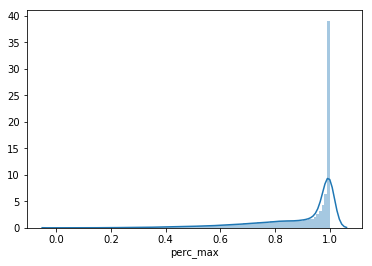

In [69]:
sns.distplot(features_agg['perc_max'], bins=100 )

# Possible Approach to cleaning missing records in a reasonable trip
1. Using the plot above, find a suitable cut-off point for data with % missing that we cannot accept. Just remove heartlessly. Maybe 95%. 
2. For each bookingID, find whether the missing records are consecutive or dispersed. 
    - If dispersed (e.g. phone only records telematics data every 5 seconds), we might be able to impute if the interval is small. 
    - If it's consecutive, go to next step
3. For chunks of missing data, find out whether the remaining data has enough value for our purposes
    - If it's one big chunk, do we still want to keep information about the other sections of the trip? (see plot about visualizing missing data below)
    - If it's several small chunks, can we get enough information out of the trip? 

Note the limitation here is that we do not know for sure whether the last known 'second' of the trip is truly the last - what if the driver ended the trip but continued to send the passenger elsewhere? I don't think this is important, but perhaps should note as an assumption.

In [ ]:
# clean clean clean

##### Visualizing Missing Data
For a single booking ID, we can visualize which part of their trip has missing data.

173546                    0.00
1072483                   1.00
839340                    2.00
835391                    3.00
1602065                   4.00
Name: second, dtype: float64


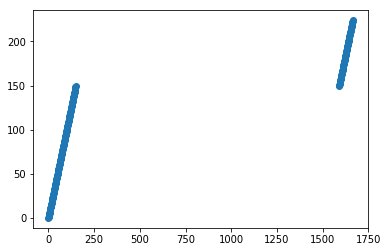

In [75]:
id = 120259084406
print(df_noImpossible[df_noImpossible.bookingID == id].second.head())
plt.scatter(df_noImpossible[df_noImpossible.bookingID == id].second,
            np.arange(0,len(df_noImpossible[df_noImpossible.bookingID == id])))

Implementation of the suggested apporach: 
1. Find what are the missing elements (`missing_elements` function)
2. Find the position of th emissing elements (`np.diff()` function)
3. ARE THEY CONSECUTIVE 

In [83]:
def missing_elements(L):
    start, end = L[0], L[-1]
    return sorted(set(range(start, end + 1)).difference(L))

id = 7 # some random bookingID
ls = list(df_noImpossible[df_noImpossible.bookingID == id].second.astype('int'))
missing_elements(ls)

[11, 28, 30, 37, 235, 360, 409, 587, 705, 707, 792]

#### Missing Data
Possibly with `.rolling()` and mean.

In [73]:
# impute pute pute

## Save the cleaned data

In [85]:
df_sorted.to_pickle('../data/features/sorted.pkl')